In [116]:
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import numpy as np

In [117]:
sc = pyspark.SparkContext.getOrCreate()
spark = SparkSession.builder.appName('BigDataApp').getOrCreate()

In [118]:
path = "../data/processed/accidents/*.csv"
dataDF = spark.read.format("csv").option("header", "true").load(path)

In [119]:
# ref: https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')

## Number of accidents per sex

In [120]:
person_types = dataDF.select("descripcio_tipus_persona").distinct()
person_types_lst = [row.descripcio_tipus_persona for row in person_types.collect()]

driverDF = dataDF.filter(dataDF.descripcio_tipus_persona == "Conductor")
drvr_manDF = driverDF.filter(driverDF.descripcio_sexe == "Home")
drvr_womanDF = driverDF.filter(driverDF.descripcio_sexe == "Dona")
drvr_unknownDF = driverDF.filter(driverDF.descripcio_sexe == "Desconegut")

passerbyDF = dataDF.filter(dataDF.descripcio_tipus_persona == "Vianant")
passrb_manDF = passerbyDF.filter(passerbyDF.descripcio_sexe == "Home")
passrb_womanDF = passerbyDF.filter(passerbyDF.descripcio_sexe == "Dona")
passrb_unknownDF = passerbyDF.filter(passerbyDF.descripcio_sexe == "Desconegut")

passengerDF = dataDF.filter(dataDF.descripcio_tipus_persona == "Passatger")
pssng_manDF = passengerDF.filter(passerbyDF.descripcio_sexe == "Home")
pssng_womanDF = passengerDF.filter(passerbyDF.descripcio_sexe == "Dona")
pssng_unknownDF = passengerDF.filter(passerbyDF.descripcio_sexe == "Desconegut")

man_lst = [drvr_manDF.count(), passrb_manDF.count(), pssng_manDF.count()]
woman_lst = [drvr_womanDF.count(), passrb_womanDF.count(), pssng_womanDF.count()]
unknown_lst = [drvr_unknownDF.count(), passrb_unknownDF.count(), pssng_unknownDF.count()]

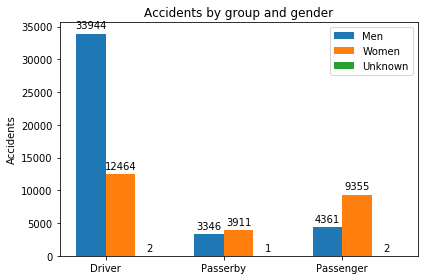

In [121]:
ind = np.arange(len(man_lst))  # the x locations for the groups
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, man_lst, width, label='Men')
rects2 = ax.bar(ind + width/2, woman_lst, width, label='Women')
rects3 = ax.bar(ind + width*1.5, unknown_lst, width, label='Unknown')

ax.set_ylabel('Accidents')
ax.set_title('Accidents by group and gender')
ax.set_xticks(ind)
ax.set_xticklabels(('Driver', 'Passerby', 'Passenger'))
ax.legend()

autolabel(rects1, "center")
autolabel(rects2, "center")
autolabel(rects3, "center")

fig.tight_layout()
plt.show()

## Passerby Accidents by Age

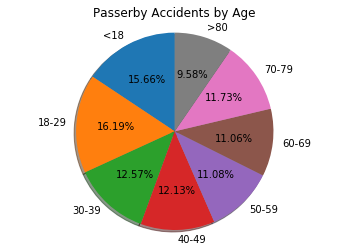

In [122]:
agelt18 = passerbyDF.filter(passerbyDF.edat < 18).count()
age18_29 = passerbyDF.filter((passerbyDF.edat >= 18) & (passerbyDF.edat <= 29)).count()
age30_39 = passerbyDF.filter((passerbyDF.edat >= 30) & (passerbyDF.edat <= 39)).count()
age40_49 = passerbyDF.filter((passerbyDF.edat >= 40) & (passerbyDF.edat <= 49)).count()
age50_59 = passerbyDF.filter((passerbyDF.edat >= 50) & (passerbyDF.edat <= 59)).count()
age60_69 = passerbyDF.filter((passerbyDF.edat >= 60) & (passerbyDF.edat <= 69)).count()
age70_79 = passerbyDF.filter((passerbyDF.edat >= 70) & (passerbyDF.edat <= 79)).count()
agegt80 = passerbyDF.filter(passerbyDF.edat >= 80).count()

labels = '<18', '18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '>80'
sizes = [agelt18, age18_29, age30_39, age40_49, age50_59, age60_69, age70_79, agegt80]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.2f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Passerby Accidents by Age')
plt.show()

## Histogram: Accidents Per Year

Text(0.5, 0.98, 'Histogram: Accidents Per Year')

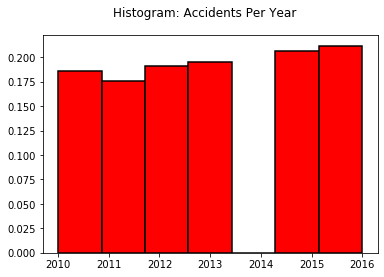

In [123]:
accidents_by_year = driverDF.select("nk_any")

year_lst = [int(row.nk_any) for row in accidents_by_year.collect()]
stats = accidents_by_year.rdd.map(lambda x: int(x[0])).stats()
releases_range = int((stats.max() - stats.min()) + 1)
plt.hist(year_lst, bins=releases_range, color='red', density=True, edgecolor='black', linewidth=1.5)
fig = plt.gcf()
fig.suptitle("Histogram: Accidents Per Year")

+----------+-----+
|mes_de_any|count|
+----------+-----+
|         7|  996|
|        11| 1077|
|         3|  991|
|         8|  749|
|         5| 1053|
|         6| 1119|
|         9| 1021|
|         1|  938|
|        10| 1029|
|         4|  986|
|        12| 1103|
|         2| 1002|
+----------+-----+



Text(0.5, 0.98, 'Histogram: Accidents by month in 2016')

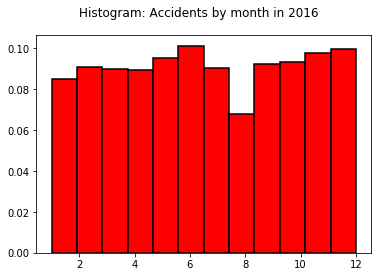

In [137]:
monthDF = dataDF.filter(dataDF.nk_any == "2016").select("mes_de_any")
monthDF.groupby("mes_de_any").count().show()

month_lst = [int(row.mes_de_any) for row in monthDF.collect()]
stats = monthDF.rdd.map(lambda x: int(x[0])).stats()
releases_range = int((stats.max() - stats.min()) + 1)
plt.hist(month_lst, bins=releases_range, color='red', density=True, edgecolor='black', linewidth=1.5)
fig = plt.gcf()
fig.suptitle("Histogram: Accidents by month in 2016")


## Accidents by Transport Methods

In [125]:
transport_groupDF = dataDF.groupby("desc_tipus_vehicle_implicat").count()

transport_type_lst = [row.desc_tipus_vehicle_implicat for row in transport_groupDF.collect()]
transport_count_lst = [row['count'] for row in transport_groupDF.collect()]

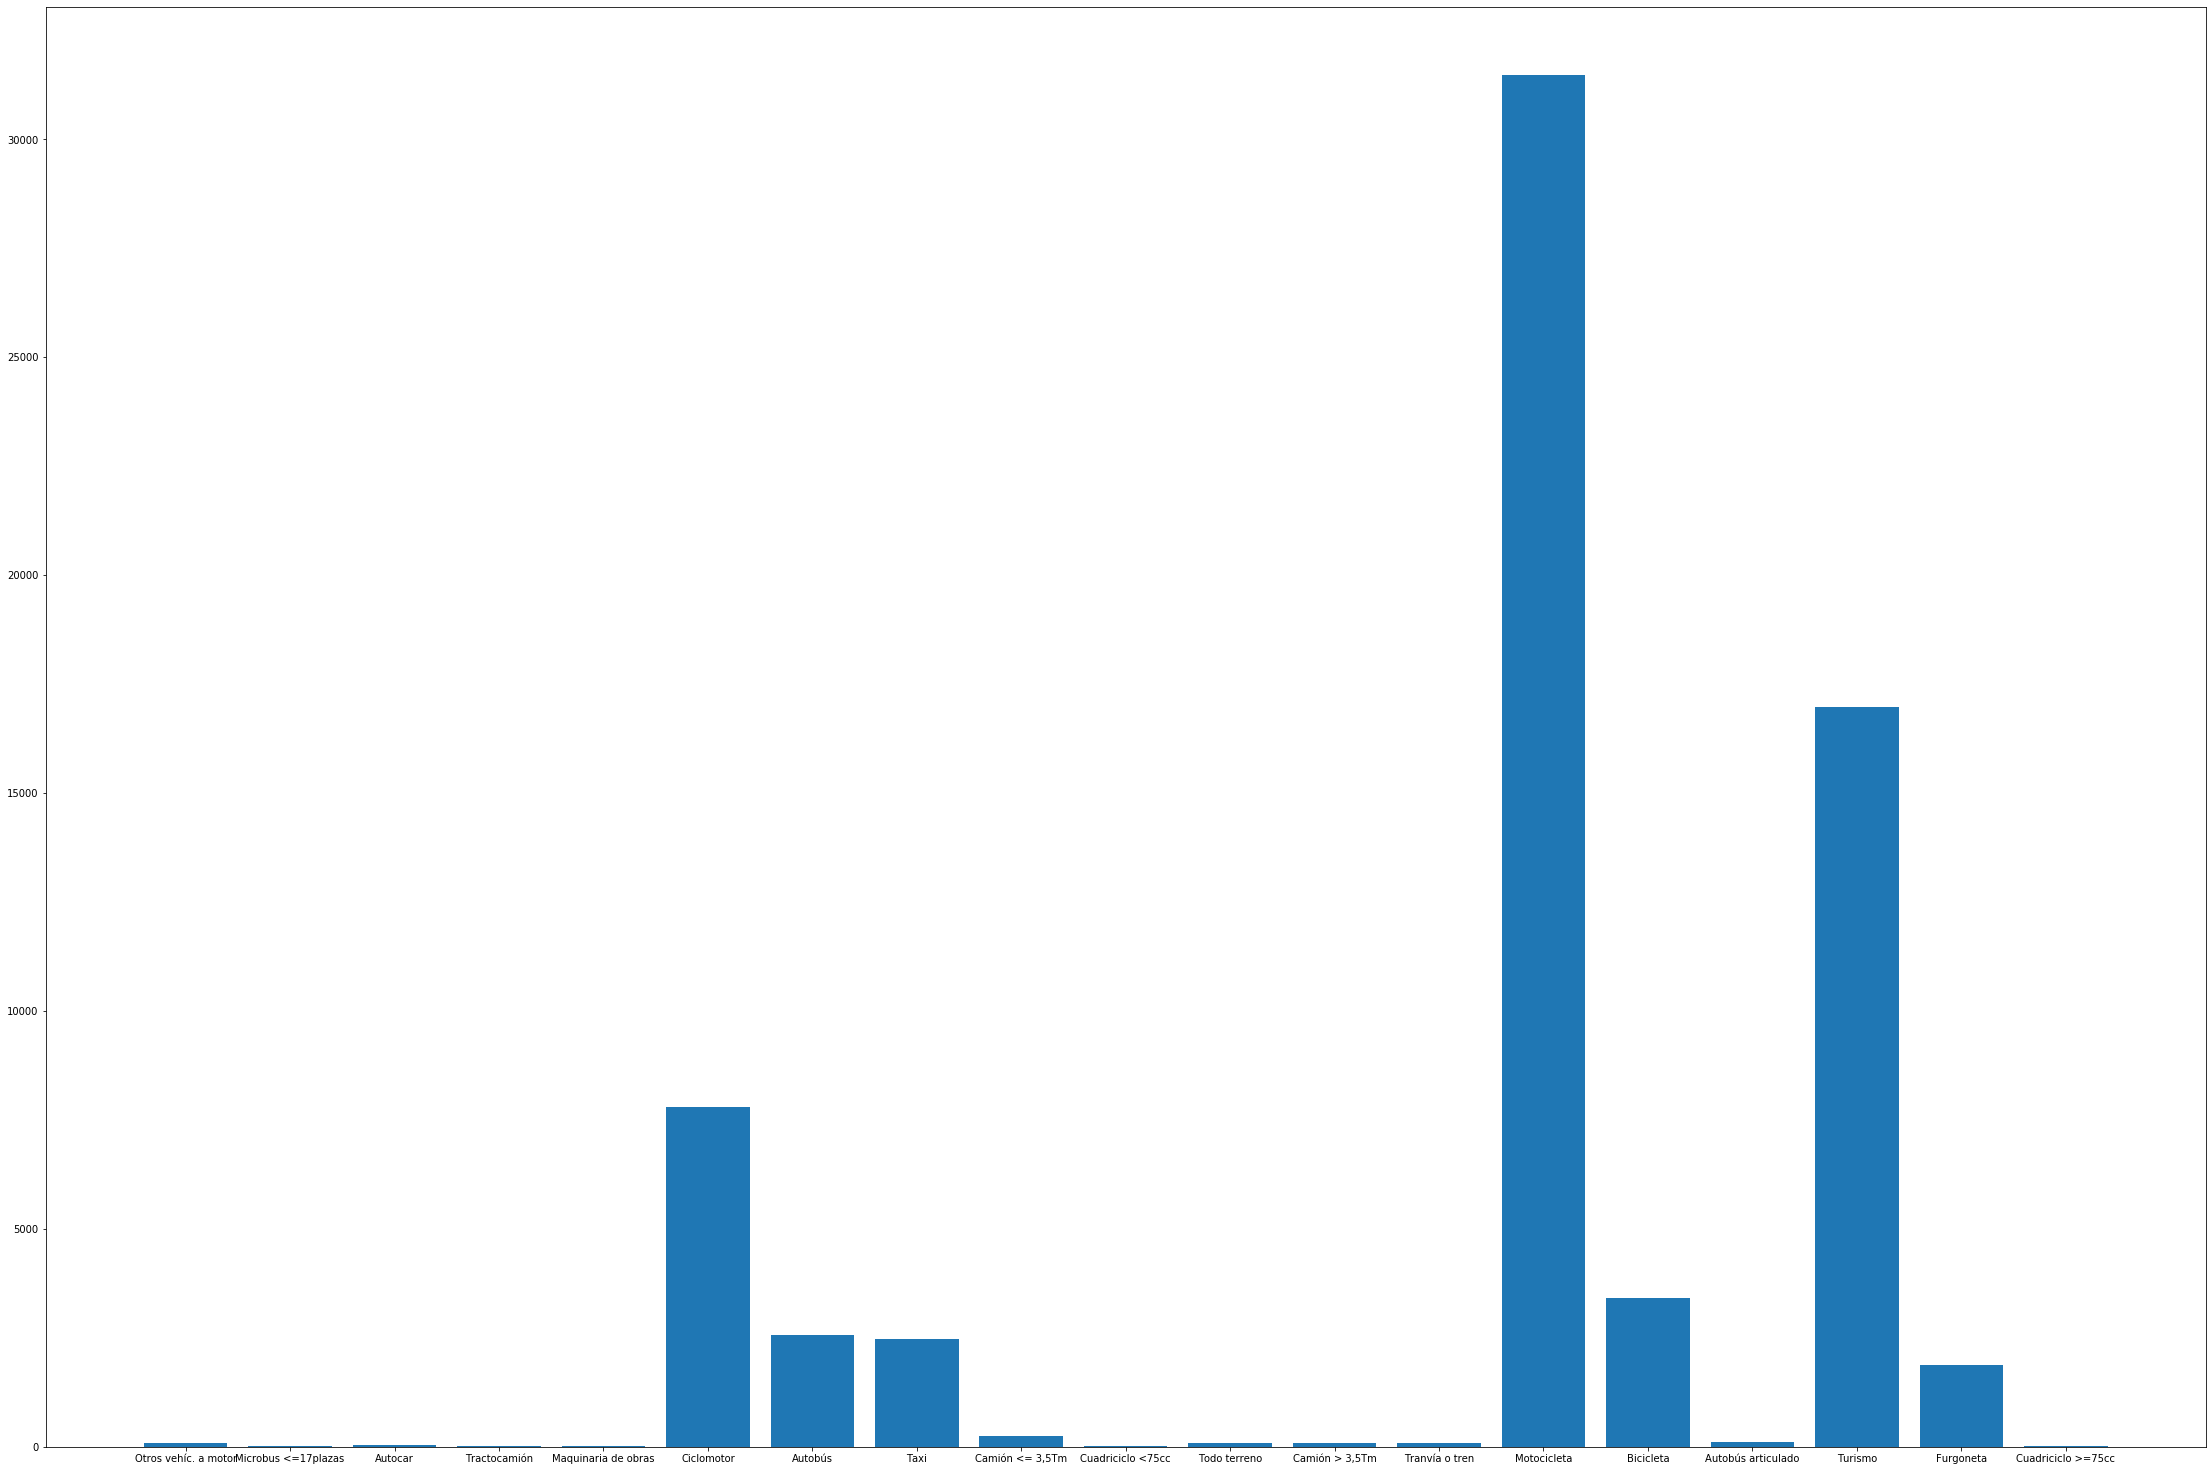

In [126]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
axbar = ax.bar(transport_type_lst, transport_count_lst)
fig.set_size_inches(30, 20)
plt.show()

In [138]:
top3accidents = dataDF.groupby("desc_tipus_vehicle_implicat").count().rdd.takeOrdered(3, key= lambda x: -x[1])
top3transports = [x.desc_tipus_vehicle_implicat for x in top3accidents]

accidents_x_transport_x_year = dataDF.select("nk_any", "desc_tipus_vehicle_implicat").rdd.\
    map(lambda x: ((x[0], x[1]), 1)).reduceByKey(lambda x, y: x+y).sortByKey(ascending=True).map(lambda x: (x[0][0], x[0][1], x[1])).\
    filter(lambda x: x[1] in top3transports)

moto = []
car = []
moped = []

for x in accidents_x_transport_x_year.collect():
    x[1] == "Motocicleta" and moto.append(x[2])
    x[1] == "Turismo" and car.append(x[2])
    x[1] == "Ciclomotor" and moped.append(x[2])


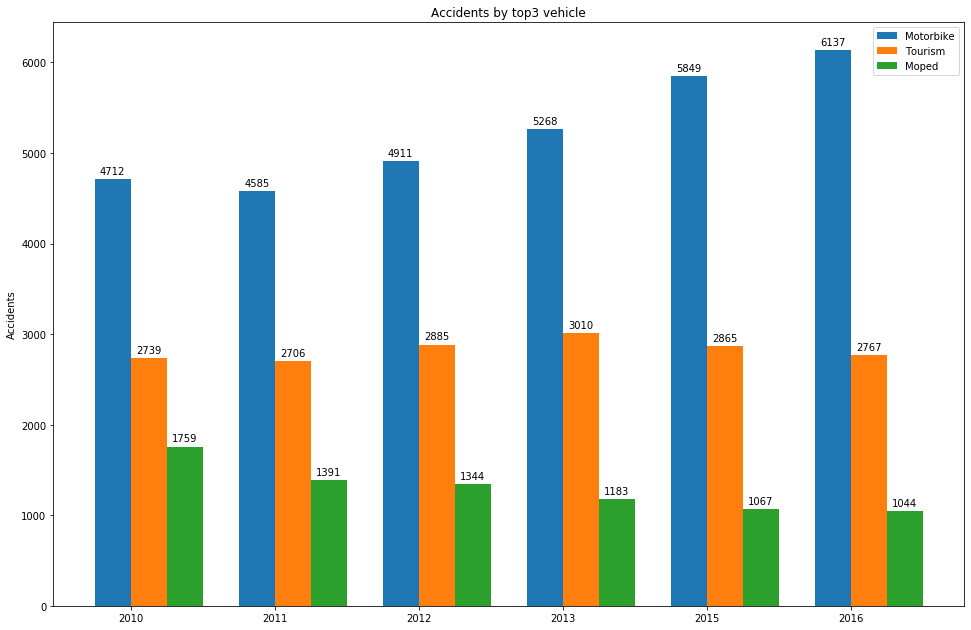

In [136]:
ind = np.arange(len(car))  # the x locations for the groups
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, moto, width, label='Motorbike')
rects2 = ax.bar(ind + width/2, car, width, label='Tourism')
rects3 = ax.bar(ind + width*1.5, moped, width, label='Moped')

ax.set_ylabel('Accidents')
ax.set_title('Accidents by top3 vehicle')
ax.set_xticks(ind)
ax.set_xticklabels(('2010', '2011', '2012', '2013', '2015', '2016'))
ax.legend()

autolabel(rects1, "center")
autolabel(rects2, "center")
autolabel(rects3, "center")

fig.tight_layout()
fig.set_size_inches(15, 10)
plt.show()